<center><h1>Making Merger Tree from m3p output</h1></center>

In [32]:
import numpy as np
import m3p_merger
import matplotlib.pyplot as plt
import importlib
import matplotlib
importlib.reload(m3p_merger)

<module 'm3p_merger' from 'C:\\Users\\David\\Google Drive\\Axion PhD\\PeakPatch\\m3p_merger\\m3p_merger.py'>

In [2]:
Omega_m0 = 0.3
Omega_r0 = 8.486e-5
h = 0.7

G = 6.674e-11 # m^3 kg^(-1) s^(-2)
Mpc = 3.086e22 # m 
Msol = 1.988e30 # kg
Mpcpkm = (1e3/3.0869e22)
H = 100*Mpcpkm*h # /s
Omega_DM = 0.267

rho_c = 3/(8*np.pi*G)*Mpc**3/Msol*H**2 # Msol / Mpc^(-3)
rho_bg = 0.267*rho_c

z_eq = Omega_m0/Omega_r0 - 1
a_eq = 1/(1+z_eq)


In [3]:
# Peak patch data
pathPrefix = "/usr/users/ellis/PeakPatch/m3p/axOut/"

In [65]:
#ppFile = pathPrefix+"../inputs/"+"inputs.ax_manyz"
ppFile = "inputs.ax_smallmanyzdis"
peak_list, boxsize = m3p_merger.MakePeakList(ppFile,startIndex = 0, printOutput = True)

	Loading file (50 of 50): axOut/smallmanyzdisfinal_halos_49.hdf5


In [30]:
peak_list.shape

(7,)

<h2><center>Find which trees are interesting</center></h2>

In [66]:
out = m3p_merger.BuildMergerTree(peak_list, ppFile, redshift_indicies='all')

for i in range(len(out)):
    if len(out[i][25]) >= 2:
        print(i, end = '* ')

96* 155* 218* 223* 255* 284* 286* 314* 328* 455* 456* 473* 528* 561* 577* 642* 660* 668* 716* 822* 911* 999* 1015* 1020* 1207* 1216* 1235* 1236* 1240* 1305* 1334* 1422* 1427* 1445* 1477* 1526* 1528* 1598* 1636* 1647* 1665* 1676* 1779* 1797* 1822* 1892* 1913* 1986* 2006* 2049* 2052* 2075* 2189* 2234* 2274* 2285* 2334* 2391* 2498* 2603* 2607* 2624* 2630* 2664* 2700* 2709* 2717* 2723* 2740* 2763* 2819* 2824* 2830* 2885* 2913* 2929* 2982* 3038* 3044* 3055* 3063* 3064* 3072* 3077* 3113* 3230* 3265* 3296* 3315* 3403* 3404* 3464* 3496* 3516* 3573* 3611* 3686* 3687* 3797* 3825* 3858* 3884* 3943* 4009* 4061* 4067* 4099* 4200* 4205* 4240* 4268* 4330* 4336* 4389* 4416* 4448* 4476* 4551* 4571* 4629* 4645* 4651* 4671* 4683* 4754* 4767* 4773* 4786* 4797* 4812* 4926* 5037* 5117* 5123* 5144* 5203* 5219* 5242* 5251* 5291* 5349* 5478* 5498* 5501* 5525* 5723* 5778* 5826* 5831* 5877* 6045* 6073* 6074* 6111* 6253* 6323* 6381* 6382* 6412* 6508* 6545* 6574* 6605* 6654* 6725* 6773* 6774* 6858* 6884* 6990* 705

<h2><center>Calculate Merger Tree</center></h2>

In [45]:
importlib.reload(m3p_merger)
#indicies = np.arange(1000)
out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 2707)
#np.save("./FinalGraphs/Data/MergerTreeExample.npy",out[0])

In [67]:
importlib.reload(m3p_merger)
out2 = m3p_merger.BuildMergerTree2(peak_list, ppFile, final_halos_indicies = 9247)

<h2><center>Plot all peaks on each other</center></h2>

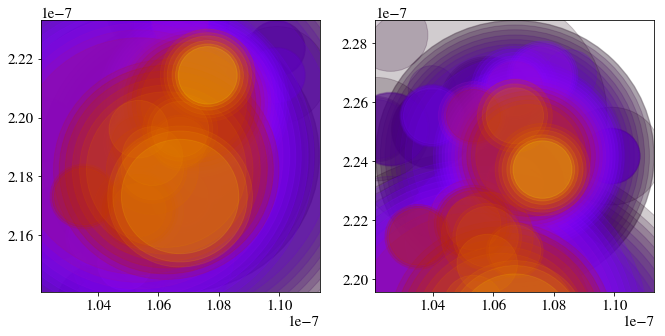

In [68]:
importlib.reload(m3p_merger)
#out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 797, printOutput = True)
m3p_merger.plotMergerPatches(out2[0], ppFile)

<h2><center>Plot merger tree</center></h2>

C:\Users\David\Google Drive\Axion PhD\PeakPatch\m3p_merger\m3p_merger.py:521: RuntimeWarning: invalid value encountered in log10
  colorVal = scalarMap.to_rgba(np.log10(merger_list[i][j,4]))
C:\Users\David\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


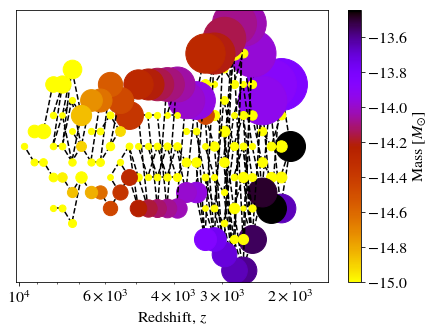

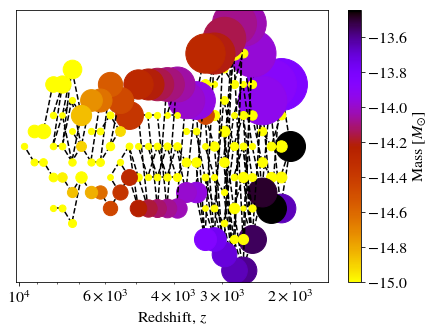

In [79]:
importlib.reload(m3p_merger)
ppFile = "inputs.ax_smallmanyzdis"
out = m3p_merger.BuildMergerTree2(peak_list, ppFile, final_halos_indicies = 9247)
fig = m3p_merger.plotMergerTree(out[0], ppFile, startIndex=0, font_size = 16, log = True,
                          colorbar=True, colorbar_title = "Mass [$M_{\odot}$]")
plt.show()
ppFile = "inputs.ax_smallmanyznodis"
out2 = m3p_merger.BuildMergerTree2(peak_list, ppFile, final_halos_indicies = 9247)
fig = m3p_merger.plotMergerTree(out2[0], ppFile, startIndex=0, font_size = 16, log = True,
                          colorbar=True, colorbar_title = "Mass [$M_{\odot}$]")

<h3>Checking Linear Interpolation</h3>

(10000.0, 1000.0)

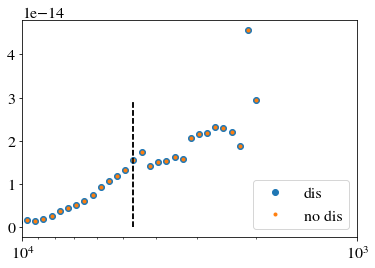

In [75]:
importlib.reload(m3p_merger)

halo_index = 18310
f = 0.01

ppFile = "inputs.ax_smallmanyzdis"
out = m3p_merger.BuildMergerTree2(peak_list, ppFile, final_halos_indicies = halo_index)
#zColLin, ProgMassLin, zLin = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 25, interp = "Linear")
zCol, ProgMass, z = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 0, interp = "None")
plt.semilogx(z, ProgMass, 'o', ms=6, label = "dis")

#plt.semilogx([zColLin, zColLin], [0,ProgMassLin[0]],'k-')
plt.semilogx([zCol, zCol], [0,ProgMass[0]],'k--')

plt.semilogx([2e4, 1e4], [ProgMass[0]/2,ProgMass[0]/2],'g--')

plt.xlim(1e4, z[0])

ppFile = "inputs.ax_smallmanyznodis"
out = m3p_merger.BuildMergerTree2(peak_list, ppFile, final_halos_indicies = halo_index)
zCol, ProgMass, z = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 0, interp = "None")
plt.semilogx(z, ProgMass, '.', ms=6, label ="no dis")

plt.semilogx([zCol, zCol], [0,ProgMass[0]],'k--')

plt.semilogx([2e4, 1e4], [ProgMass[0]/2,ProgMass[0]/2],'g--')
plt.legend(loc=4)
plt.xlim(1e4, 1e3)


#np.save("./FinalGraphs/Data/MassGrowth.npy", [z, ProgMass, zCol])

In [19]:
importlib.reload(m3p_merger)
ppFile = "inputs.axbig_manyz"

frac = 0
startIndicies = [0, 25, 50, 74]

for i, startIndex in enumerate(startIndicies):  
    z0 = np.logspace(2,6,100)[startIndex]
    
    print("-"*40)
    print("Calculating collapse redshifts\n   ppFile: {}\n   z0={:.3}\n".format(ppFile, z0))
    
    print("Building peak list...")
    peak_list, boxsize = m3p_merger.MakePeakList(ppFile, startIndex = startIndex, printOutput = True)
    print("Done.\n")

    print("Building merger trees...")
    out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = "all", printOutput = True)
    print("Done.\n")

    print("Calculating collapse redshifts...")
    collapse_redshifts = np.zeros(len(out))
    for i in range(len(out)):
        collapse_redshifts[i] = m3p_merger.FindCollapseRedshift(out[i], frac, ppFile, interp = "None")[0]
    print("Done.\n")

    print("Fetching final halo masses...")
    masses = np.zeros(len(out))
    for i in range(len(out)):
        masses[i] = out[i][0][0,4]
    print("Done.\n")

    print("Fetching final halo radii...")
    radii = np.zeros(len(out))
    for i in range(len(out)):
        radii[i] = out[i][0][0,3]
    print("Done.\n")

    print("Saving data...")
    np.save("ConcEvolution/axbig_manyz_CollapseRedshifts_f0_z0_{}".format(z0), collapse_redshifts)
    np.save("ConcEvolution/axbig_manyz_FinalMasses_f0_z0_{}".format(z0), masses)
    np.save("ConcEvolution/axbig_manyz_FinalRadii_f0_z0_{}".format(z0), radii)
    print("Done.\n")

----------------------------------------
Calculating collapse redshifts
   ppFile: inputs.axbig_manyz
   z0=1e+02

Building peak list...
	Loading file (100 of 100): axOut/axionfinal_halos_99.hdf5
Done.

Building merger trees...
	Final redshift index 99 out of 100
	i.e. Earlist halo at z = 1000000.0
	Halo 3110 of 3111: 99 complete of 99
Done.

Calculating collapse redshifts...
Done.

Fetching final halo masses...
Done.

Fetching final halo radii...
Done.

Saving data...
Done.

----------------------------------------
Calculating collapse redshifts
   ppFile: inputs.axbig_manyz
   z0=1.02e+03

Building peak list...
	Loading file (75 of 75): axOut/axionfinal_halos_99.hdf5
Done.

Building merger trees...
	Final redshift index 74 out of 75
	i.e. Earlist halo at z = 97700.0
	Halo 125458 of 125459: 74 complete of 74
Done.

Calculating collapse redshifts...
Done.

Fetching final halo masses...
Done.

Fetching final halo radii...
Done.

Saving data...
Done.

------------------------------------

In [99]:
np.where(zs == min(zs[zs>2507]))

(array([35], dtype=int64),)

In [97]:
zs[10]

253.53644939701115

array([array([[1.4765625e-08, 6.7204689e-07, 1.9785938e-07, 4.5879971e-09,
        3.5040550e-14]], dtype=float32),
       array([[1.8140627e-08, 6.7289068e-07, 1.9617188e-07, 4.2283728e-09,
        2.7429720e-14]], dtype=float32),
       array([[1.2234375e-08, 6.7035938e-07, 1.9617188e-07, 2.9086620e-09,
        8.9285565e-15],
       [1.8140627e-08, 6.7289068e-07, 1.9617188e-07, 4.2166244e-09,
        2.7201713e-14]], dtype=float32),
       array([[1.5609377e-08, 6.7120317e-07, 1.9954688e-07, 2.3998219e-09,
        5.0146256e-15],
       [1.2234375e-08, 6.7035938e-07, 1.9617188e-07, 2.8522431e-09,
        8.4190103e-15],
       [1.8140627e-08, 6.7289068e-07, 1.9617188e-07, 4.1396264e-09,
        2.5738602e-14]], dtype=float32),
       array([[1.4765625e-08, 6.7204689e-07, 1.9785938e-07, 4.1930899e-09,
        2.6748780e-14]], dtype=float32),
       array([[1.4765625e-08, 6.7204689e-07, 1.9785938e-07, 4.1720338e-09,
        2.6347837e-14]], dtype=float32),
       array([[1.4765625e-08

In [8]:
2/3*(1-0.6)

0.26666666666666666

In [63]:
for i in np.logspace(4.5, np.log10(2000), 50)[::-1]:
    print("{:.3}".format(i), end = ' ')

2e+03 2.12e+03 2.24e+03 2.37e+03 2.51e+03 2.65e+03 2.8e+03 2.97e+03 3.14e+03 3.32e+03 3.51e+03 3.72e+03 3.93e+03 4.16e+03 4.4e+03 4.66e+03 4.93e+03 5.21e+03 5.51e+03 5.83e+03 6.17e+03 6.53e+03 6.91e+03 7.31e+03 7.73e+03 8.18e+03 8.65e+03 9.16e+03 9.69e+03 1.02e+04 1.08e+04 1.15e+04 1.21e+04 1.28e+04 1.36e+04 1.44e+04 1.52e+04 1.61e+04 1.7e+04 1.8e+04 1.9e+04 2.01e+04 2.13e+04 2.26e+04 2.39e+04 2.52e+04 2.67e+04 2.83e+04 2.99e+04 3.16e+04 